In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import eigvals as eig
import seaborn as sns
from collections import Counter
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
import gc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from scipy.linalg import eigvals

sns.set()
%matplotlib inline

## Подготовка таблицы

In [2]:
df = pd.read_csv("201", sep = "\t")
df.drop(columns = ["payment_type"], inplace = True)
df["event_time"] =  pd.to_datetime(df["event_time"])
df = df.sort_values(by=['event_time'])
dummy = pd.get_dummies(df["event"])
dummy.drop(columns = ["ba_became_paid", "ba_created", "cloud_created", "day_use", \
                      "first_paid_consumption", "first_payment", "first_trial_consumption"], inplace = True)
df = pd.concat([df, dummy], axis = 1)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sku = pd.read_csv("sku_tags.csv")
sku.drop(columns = ["service_name", "sku_id"], inplace = True)

services = ['compute', 'network', 'storage', 'managed_databases',
            'container_registry', 'artificial_intelligence',
            'network_load_balancer', 'yandex_message_queue']

subservices_hash_map = {}
for service in services:
    subservices = sku[sku["service_long_name"] == service]["subservice_name"].unique()
    subservices = ["subservice_" + col for col in subservices]
    subservices_hash_map[service] = subservices

In [4]:
core_cols = ['core_5.0', 'core_fraction_10.0', 'core_fraction_20.0', 'core_fraction_50.0', \
             'core_100.0']
platform_cols = ['platform_v1', 'platform_v2']
database_cols = ['clickhouse', 'mongo', 'ms_sql', 'mysql', 'pg', 'redis']
preemtible_col = ['preemtible_is']

In [5]:
sku = pd.read_csv("sku_tags.csv")
sku.drop(columns = ["service_name", "sku_id"], inplace = True)

dummy = pd.get_dummies(sku["core_fraction"])
dummy.columns = ["core_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["core_fraction"], inplace = True)

dummy = pd.get_dummies(sku["database"])
dummy.columns = ["database_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["database"], inplace = True)

dummy = pd.get_dummies(sku["platform"])
dummy.columns = ["platform_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["platform"], inplace = True)

dummy = pd.get_dummies(sku["preemptible"])
dummy.columns = ["preemtible_is"]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["preemptible"], inplace = True)

dummy = pd.get_dummies(sku["service_long_name"])
sku = pd.concat([sku, dummy], axis = 1)

dummy = pd.get_dummies(sku["subservice_name"])
dummy.columns = ["subservice_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
#sku.drop(columns = ["subservice_name"], inplace = True)


In [6]:
df = df.merge(sku, left_on='sku_name', right_on = "sku_name", how = "left")
df.drop(columns = ["sku_name"], inplace = True)

## Общее

In [7]:
class Client:
    def __init__(self, puid, acc_num, ba_currency, ba_person_type, segment,
                 ba_payment_cycle_type, service_long_name):
        self.id = puid
        self.payed_acc_num = acc_num
        self.ba_currency = ba_currency
        self.ba_person_type = ba_person_type
        self.segment = segment
        self.ba_payment_cycle_type = ba_payment_cycle_type
        self.service_long_name = service_long_name
        self.out_of_cloud = False
        self.weeks_in_cloud = -1
        
    def print_info(self):
        print("Client INFO\n==================================")
        print("puid:", self.id)
        print("payed_acc_num:", self.payed_acc_num)
        print("ba_currency:", self.ba_currency)
        print("ba_person_type:", self.ba_person_type)
        print("segment:", self.segment)
        print("ba_payment_cycle_type:", self.ba_payment_cycle_type)
        print("service_long_name:", self.service_long_name)
        print("out_of_cloud:", self.out_of_cloud)
        print("weeks_in_cloud:", self.weeks_in_cloud)
        print("==================================")

In [8]:
def calculate_client_info(curr_sku, df_curr):
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    puids = df["puid"].unique()
    print("Common info\n====================")
    print("unique users:", df["puid"].unique().shape)
    print("====================")
    df_grouped = df_curr.groupby(["puid"])
    hashed_clients = {}
    for puid, df_account in df_grouped:
        
        if puid not in puids:
            continue
        df_account = df_account[(df_account["service_long_name"] == curr_sku) |
                                (df_account["event"] != "day_use")]
        
        if df_account["ba_currency"].unique().shape[0] > 1:
            print(df_account["ba_currency"].unique())

        acc_num = df_account["billing_account_id"].unique().shape[0]
        ba_currency = df_account["ba_currency"].unique()[0]
        ba_person_type = np.array(df_account["ba_person_type"].unique())
        ba_person_type = ba_person_type[~pd.isnull(ba_person_type)]

        if ba_person_type.shape[0] > 1: 
            #print(df_account.head())
            #print(bill_id, df_account["ba_person_type"].unique())
            ba_person_type = np.array(['company'])

        if ba_person_type.shape[0] == 0:
            ba_person_type = np.array(['no_type'])

        segment = np.array(df_account["segment"].unique())
        if segment.shape[0] > 1: 
            #print(bill_id, df_account["segment"].unique())
            segment = [df_account["segment"].iloc[-1]]

        ba_payment_cycle_type = np.array(df_account["ba_payment_cycle_type"].unique())
        if ba_payment_cycle_type.shape[0] > 1: 
            #print(bill_id, df_account["segment"].unique())
            ba_payment_cycle_type = [df_account["ba_payment_cycle_type"].iloc[-1]]
            print(ba_payment_cycle_type)

        service_long_name = np.array(df_curr[df_curr["puid"] == puid]["service_long_name"].unique())
        service_long_name = service_long_name[~pd.isnull(service_long_name)]
        #print(bill_id, ba_currency, ba_person_type, segment,
         #            ba_payment_cycle_type, service_long_name)
        hashed_clients[puid] = Client(puid, acc_num, ba_currency, ba_person_type[0], segment[0],
                     ba_payment_cycle_type[0], service_long_name)

    print("OK")
    return hashed_clients

In [9]:
def make_simple_analysis(curr_sku, df_curr):
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    curr = df.groupby([pd.Grouper(key='event_time', freq='W-Mon')])['real_consumption'].sum()\
                                .reset_index().sort_values('event_time')
    curr = curr[curr["event_time"] <= last_date]
    plt.figure(figsize = (10, 7))
    plt.title("Real consumption в неделю для {}".format(curr_sku), fontsize = 15)
    plt.plot(curr["event_time"], curr["real_consumption"], color = "orange")
    plt.xlabel("дата", fontsize = 15)
    plt.ylabel("Real consumption", fontsize = 15)

In [10]:
add_hash_map = {}
add_hash_map["core_fraction"] = ['core_5.0', 'core_10.0', 'core_20.0', 'core_50.0', 'core_100.0']
add_hash_map["platform"] = ['platform_v1', 'platform_v2']
add_hash_map["database"] = ['database_clickhouse', 'database_mongo', 'database_ms_sql', 
                            'database_mysql', 'database_pg', 'database_redis']
add_hash_map["preemptible"] = ['preemtible_is']

In [11]:
services = ['compute', 'network', 'storage', 'managed_databases',
            'container_registry', 'artificial_intelligence',
            'network_load_balancer', 'yandex_message_queue']

In [12]:
def prepare_service_sku_columns(curr_sku):
    sku = pd.read_csv("sku_tags.csv")
    sku.drop(columns = ["service_name", "sku_id"], inplace = True)
    add_cols = ["core_fraction", "database", "platform", "preemptible"]
    ans = []
    for col in add_cols:
        vals = np.array(sku[sku["service_long_name"] == curr_sku][col].unique())
        vals = vals[~pd.isnull(vals)]
        if vals.shape[0] != 0:
            for new_col in add_hash_map[col]:
                ans.append(new_col)
    for new_col in subservices_hash_map[curr_sku]:
        ans.append(new_col)
    return ans

## MDB

In [13]:
mdb_curr_sku = 'managed_databases'

In [14]:
mdb_hashed_clients = calculate_client_info(mdb_curr_sku, df)

Common info
unique users: (465,)
OK


In [15]:
last_date = np.datetime64('2019-07-01')

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


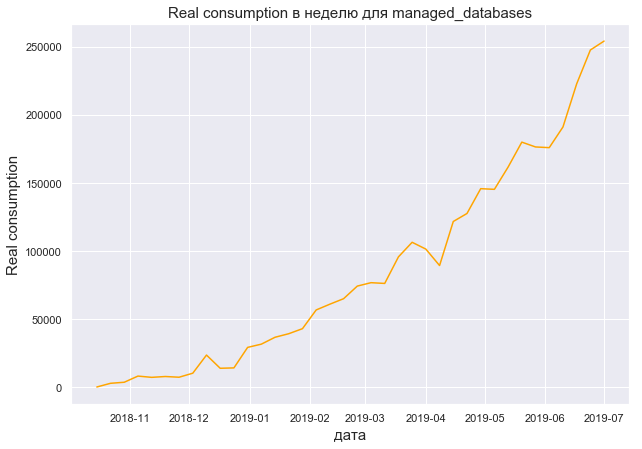

In [16]:
make_simple_analysis(mdb_curr_sku, df)

In [17]:
mdb_cols = prepare_service_sku_columns(mdb_curr_sku)

In [19]:
gc.collect()

2265

In [20]:
def prepare_columns_inside_table_creator(add_cols):
    person_cols = ["month", "puid", "out_of_cloud", "ba_person_type", "segment", \
                   "ba_payment_cycle_type", "weeks_in_cloud", \
                   "avg_day_consumption", "max_day_consumption", "non_zero_days_consumption",\
                   "visits", "clicks", "calls"]
    val = "sum"
    add_dict = {}
    for col in add_cols:
        add_dict[col] = val
        person_cols.append("avg_" + col)
        person_cols.append("max_" + col)
        person_cols.append("non_zero_days_" + col)
    for service in services:
        person_cols.append("consumption_service_" + service)

    for i in range(4, 0, -1):
        person_cols.append("real_consumption_" + str(-i))
    return person_cols, add_dict


def raw_info_getter(curr_sku, puid, df_account, hashed_clients, add_cols):
    
    curr_cons = df_account.groupby([pd.Grouper(key='event_time', freq = "d")]).agg({
        'real_consumption':"sum"
    }).reset_index().sort_values('event_time')     
    
    additional_consump = {}
    
    for col in add_cols:
        curr_add_df = df_account[df_account[col] > 0.5]
        #print(curr_add_df)
        add_df_temp = curr_add_df.groupby([pd.Grouper(key='event_time', freq = "d")]).agg(\
         {'real_consumption':"sum"}).reset_index().sort_values('event_time')
        additional_consump[col] = np.array(add_df_temp["real_consumption"])

    consumptions = np.array(curr_cons['real_consumption'])
    clicks = df_account['click_mail'].sum()
    visits = df_account['visit'].sum()
    calls = df_account['call'].sum()
    return consumptions, clicks, visits, calls, additional_consump


def last_preparation_table_inside_table_creator(person_df):
    
    person_df["puid"] = pd.to_numeric(person_df["puid"])
    person_df["out_of_cloud"] = pd.to_numeric(person_df["out_of_cloud"])
    person_df["weeks_in_cloud"] = pd.to_numeric(person_df["weeks_in_cloud"])
    
    patterns = ["num_", "clicks", "non_zero_days_", \
                "calls", "visits", "max_", "avg_", "consumption_", "real_consumption"]
    type_cols = [i for i in person_df.columns if any(x in i for x in patterns)]
    for col in type_cols:
        person_df[col] = pd.to_numeric(person_df[col])
    return person_df

def adding_person_mean_max_non_zero_info(person_row, arr):
    person_row.append(np.sum(arr) / 30)
    person_row.append(np.max(arr))
    person_row.append(np.count_nonzero(arr))

def person_row_creator(month,
                       puid,
                       out_of_cloud, 
                       ba_person_type, 
                       segment, 
                       ba_payment_cycle_type, 
                       weeks_in_cloud,
                       consumptions,
                       visits,
                       clicks,
                       calls,
                       add_cols,
                       additional_consump):
    person_row = [month, puid, out_of_cloud, ba_person_type, segment, 
                  ba_payment_cycle_type, weeks_in_cloud]

    #if curr_client.id == 4299035:
    #    print(consumptions)
    #    print(np.mean(consumptions))

    adding_person_mean_max_non_zero_info(person_row, consumptions)
    person_row.append(visits)
    person_row.append(clicks)
    person_row.append(calls)

    for col in add_cols:
        if additional_consump[col].shape[0] == 0:
            person_row.append(0)
            person_row.append(0)
            person_row.append(0)
            continue
        adding_person_mean_max_non_zero_info(person_row, additional_consump[col])
    return person_row



In [21]:
def person_table_creator(curr_sku, df_curr, hashed_clients, add_cols, last_date_of_observing):
    person_cols, add_dict = prepare_columns_inside_table_creator(add_cols)
    count = 1
    person_count = 1
    dropped_users = 0
    person_df = pd.DataFrame(columns = person_cols)
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    puids = df["puid"].unique()
    print("Common info\n====================")
    print("unique users:", puids.shape[0])
    print("====================")
    df_grouped = df_curr.groupby(["puid"])
    plt.figure(figsize = (10, 7))
    for puid, df_account in tqdm(df_grouped):
    
        if puid not in puids:
            continue
        
        df_account = df_account[((df_account["service_long_name"] == curr_sku) &
                                 ~(df_account["subservice_name"].isin(['network-hdd', 'network-nvme', 'public_ip'])))|
                                (df_account["event"] != "day_use")]
        #ограничим просмотром только на следующий месяц
        df_account = df_account[df_account['event_time'] <= last_date_of_observing]
        if df_account[df_account['real_consumption'] >= 0.01].shape[0] == 0: #не было вообще потребления
            continue
        
        last_dt = df_account[df_account['real_consumption'] >= 0.01]["event_time"].iloc[-1]
        
        dropped = False
        # Если в последний раз потребление было ранее предсказываемого месяца, то он ушел, иначе остался
        #(при этом ограничились просмоторм макс след месяцем)
        if  last_dt < last_date_of_observing - pd.Timedelta(30, unit='d'):
            dropped = True
        
        # Теперь смотрим только на информацию по 30 последним активным дням
        min_dt = last_dt - pd.Timedelta(30, unit='d')
        df_account = df_account[(df_account['event_time'] <= last_dt)]

        weeks_in_cloud = df_account['event_time'].iloc[-1] - df_account['event_time'].iloc[0]
        weeks_in_cloud = weeks_in_cloud.days / 7
        
        df_account = df_account[(df_account['event_time'] >= min_dt)]
        
        #посчитаем метрики по дням
        consumptions, clicks, \
        visits, calls, additional_consump = raw_info_getter(curr_sku, puid, 
                                                                     df_account, hashed_clients, add_cols)
        
        curr_client = hashed_clients[puid]
        
        last_days = 29
        if consumptions.shape[0] < 29:
            continue
    
        
########################person_creator##################################
        person_row = person_row_creator(df_account["event_time"].iloc[0].month, 
                       puid,
                       dropped, 
                       curr_client.ba_person_type, 
                       curr_client.segment, 
                       curr_client.ba_payment_cycle_type, 
                       weeks_in_cloud,
                       consumptions,
                       visits,
                       clicks,
                       calls,
                       add_cols,
                       additional_consump)
        for service in services:
            #print(service)
            curr_cons = df_curr[(df_curr["puid"] == puid) &\
                    (df_curr["service_long_name"] == service)]["real_consumption"].sum()
            person_row.append(curr_cons)
        
        curr_cons = consumptions[-last_days:]
        for i in range(4):
            week_ans = 0
            for j in range(7):
                num = i * 7 + j
                week_ans += curr_cons[num]
            #print(week_ans)
            person_row.append(week_ans)
        #print(len(person_row), len(person_cols))
        #print(person_cols)
        person_df.loc[person_count] =  person_row
        if dropped == True:
            dropped_users += 1
        person_count += 1
########################person_creator##################################
    person_count -= 1
    person_df = last_preparation_table_inside_table_creator(person_df)
    print("Рассмотрено пользователей:", person_count)
    print("Ушло пользователей:", dropped_users)
    print("Процент ушедших пользователей:", dropped_users / person_count)
    
    return person_df

In [22]:
july = np.datetime64('2019-07-01')

In [23]:
mdb_person_df = person_table_creator(mdb_curr_sku, df,\
                                            mdb_hashed_clients, mdb_cols, july)

Common info
unique users: 465



Рассмотрено пользователей: 175
Ушло пользователей: 26
Процент ушедших пользователей: 0.14857142857142858


<Figure size 720x504 with 0 Axes>

In [24]:
mdb_person_df.drop(columns = ["month"], inplace = True)

In [25]:
gc.collect()

1732

In [26]:
mdb_person_df.head()

,puid,out_of_cloud,ba_person_type,segment,ba_payment_cycle_type,weeks_in_cloud,avg_day_consumption,max_day_consumption,non_zero_days_consumption,visits,...,consumption_service_storage,consumption_service_managed_databases,consumption_service_container_registry,consumption_service_artificial_intelligence,consumption_service_network_load_balancer,consumption_service_yandex_message_queue,real_consumption_-4,real_consumption_-3,real_consumption_-2,real_consumption_-1
1,275672,False,individual,mass,monthly,22.571429,74.400001,72.000001,31,0,...,0.000000,6936.654066,0.000000,0.0,0.0,0.000,504.000010,504.000010,504.000010,504.000010
2,4668718,False,individual,mass,monthly,21.000000,122.164802,118.224002,31,3,...,0.013638,6992.820701,0.000000,0.0,0.0,0.000,827.568017,827.568017,827.568017,827.568017
3,5579731,False,individual,mass,monthly,17.571429,277.348652,288.489605,30,2,...,1536.266147,42088.166959,0.000000,0.0,0.0,0.000,2019.427238,2019.427238,2019.427238,1610.733631
4,7003446,False,individual,mass,monthly,16.714286,17.498880,16.934400,31,0,...,0.161004,1630.012256,1.479387,0.0,0.0,0.000,118.540802,118.540802,118.540802,118.540802
5,10324308,False,individual,isv,monthly,23.285714,47.020407,45.532801,31,11,...,0.205579,9560.831372,0.000000,0.0,0.0,0.073,318.729606,318.729606,318.729606,318.729606


In [27]:
from sklearn.manifold import TSNE

In [28]:
mdb_clustering_df = mdb_person_df[["real_consumption_-4",
                                          "real_consumption_-3",
                                          "real_consumption_-2",
                                          "real_consumption_-1",
                                          "puid",
                                          "out_of_cloud"]]

In [29]:
mdb_clustering_df.head()

,real_consumption_-4,real_consumption_-3,real_consumption_-2,real_consumption_-1,puid,out_of_cloud
1,504.000010,504.000010,504.000010,504.000010,275672,False
2,827.568017,827.568017,827.568017,827.568017,4668718,False
3,2019.427238,2019.427238,2019.427238,1610.733631,5579731,False
4,118.540802,118.540802,118.540802,118.540802,7003446,False
5,318.729606,318.729606,318.729606,318.729606,10324308,False


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [31]:
def prepare_cluster_X_y(df):
    y = df["out_of_cloud"]
    cols = ["out_of_cloud", "puid"]
    if "clusters" in df.columns:
        cols.append("clusters")
    X = df.drop(columns = cols)
    #scaler = StandardScaler()
    normalizer = Normalizer()
    #X = scaler.fit_transform(X)
    X = normalizer.fit_transform(X)
    return X, y

In [32]:
X, y = prepare_cluster_X_y(mdb_clustering_df)

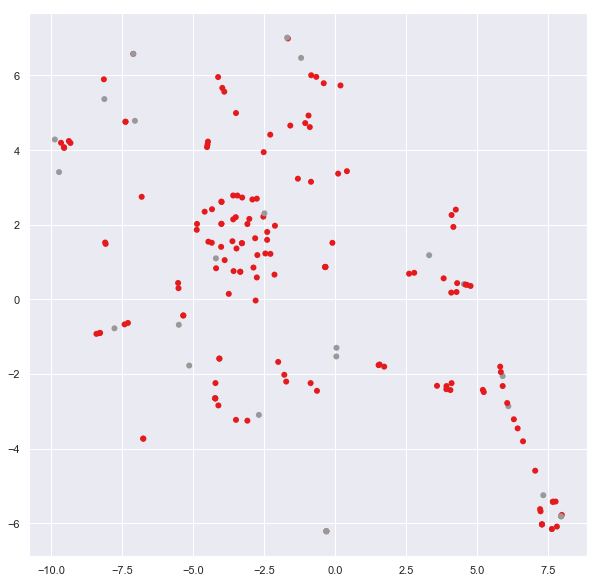

In [33]:
tsne = TSNE(n_components = 2, perplexity = 40)
Z = tsne.fit_transform(X)
plt.figure(figsize = (10, 10))
plt.scatter(Z[:, 0], Z[:, 1], c=y, linewidths=0, cmap='Set1')
plt.show()

In [34]:
from statsmodels.stats import multitest
def wald(n, m, p1, p2):
    sigma = np.sqrt(p1*(1 - p1) / n + p2 * (1 - p2) / m)
    return (p1 - p2) / sigma

def wald_test(X, Y):
    ans = sps.norm.cdf(wald(X.shape[0], Y.shape[0], np.mean(X), np.mean(y)))
    return ans

def two_sided_wald_test(X, Y):
    if wald_test(X, Y) < 0.05:
        return (True, wald_test(X, Y))
    if wald_test(Y, X) < 0.05:
        return (True, wald_test(Y, X))
    return False, min(wald_test(Y, X), wald_test(X, Y))
def in_cluster_compare(curr, min_days, curr_sku):
    cols = prepare_service_sku_columns(curr_sku)
    unreal_cols = ["non_zero_days_" + col for col in cols]
    num = 0
    pval = []
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
            continue
        num += 1
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        pval.append(res)
    
    #print(pval)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    #print("FWER: answers:", h1, "Holms corrected p_val:", holm)
    plt.figure(figsize = (15, 20))
    ind = 1
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
            continue
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        if h1[ind - 1]:
            print(name, "corrected p-val:", holm[ind - 1])
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "black")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        else:
            print(name, "corrected p-val:", holm[ind - 1])
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "orangered")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        #print("================================================================================================\n")
    plt.show()

core_100.0 corrected p-val: 1.0
database_clickhouse corrected p-val: 1.0
database_mongo corrected p-val: 1.0
database_pg corrected p-val: 1.0
platform_v1 corrected p-val: 1.0
platform_v2 corrected p-val: 0.0019159426201196103
subservice_clickhouse corrected p-val: 1.0
subservice_mongo corrected p-val: 1.0
subservice_pg corrected p-val: 1.0


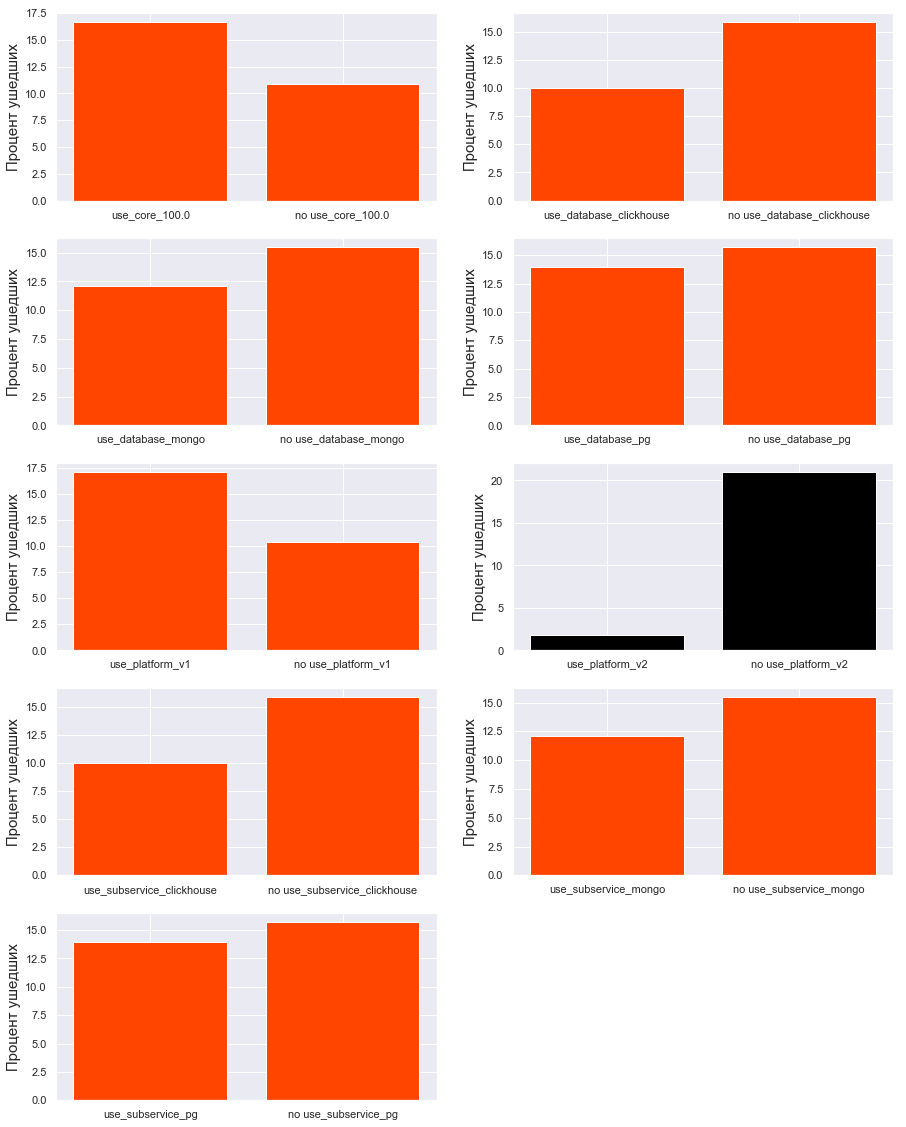

In [35]:
in_cluster_compare(mdb_person_df, 10, mdb_curr_sku)

Влияет только второй тип платформы.